# 自然語言處理
* STEP 1：[資料清整](http://localhost:8888/notebooks/Python%20Learning/nomura_fintech_nlp_analysis.ipynb#%E5%8C%AF%E5%85%A5%E5%A5%97%E4%BB%B6)
* STEP 2：[斷詞處理](http://localhost:8888/notebooks/Python%20Learning/nomura_fintech_nlp_analysis.ipynb#%E6%96%B7%E8%A9%9E%E8%99%95%E7%90%86)
* STEP 3：[詞頻計算](http://localhost:8888/notebooks/Python%20Learning/nomura_fintech_nlp_analysis.ipynb#%E8%A9%9E%E9%A0%BB%E8%A8%88%E7%AE%97)
* STEP 4：[稀疏矩陣](http://localhost:8888/notebooks/Python%20Learning/nomura_fintech_nlp_analysis.ipynb#%E7%A8%80%E7%96%8F%E7%9F%A9%E9%99%A3)
* STEP 5：[共現性矩陣](http://localhost:8888/notebooks/Python%20Learning/nomura_fintech_nlp_analysis.ipynb#%E5%85%B1%E7%8F%BE%E6%80%A7%E7%9F%A9%E9%99%A3)
* STEP 6：[資料正則化](http://localhost:8888/notebooks/Python%20Learning/nomura_fintech_nlp_analysis.ipynb#%E5%85%B1%E7%8F%BE%E6%80%A7%E7%9F%A9%E9%99%A3)
* STEP 7：[視覺化網絡圖](http://localhost:8888/notebooks/Python%20Learning/nomura_fintech_nlp_analysis.ipynb#%E8%A6%96%E8%A6%BA%E5%8C%96%E7%B6%B2%E7%B5%A1%E5%9C%96)
* STEP 8：[關鍵字間的關係](http://localhost:8888/notebooks/Python%20Learning/nomura_fintech_nlp_analysis.ipynb#%E9%97%9C%E9%8D%B5%E5%AD%97%E9%96%93%E7%9A%84%E9%97%9C%E4%BF%82)

# 作業主題：全球華爾街日報中之標題解析
# 資料來源 ： 華爾街日報（爬蟲）
# 資料時間軸 ：2020年 1月 ~ 2020年 3月

## 匯入套件

In [1]:
import nltk
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import networkx as nx
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [21]:
import networkx as nx

## 匯入資料

In [2]:
df_ori = pd.read_csv(r'C:\Users\sefx5\Desktop\WSJ_90d_data.csv',encoding = 'utf8')

## 顯示基本資料

In [3]:
df_ori.shape

(9049, 4)

In [4]:
df_ori.head()

,date,title,sub_title,content
0,1-4-2020\n,Affordable Care Act Sign-Ups Total 11.4 Mi...,ACA sign-ups steady for third straight year de...,About 11.4 million consumers signed up for hea...
1,1-4-2020,Corrections & Amplifications,NaN,Reporter Jennifer Calfas’s last name was miss...
2,1-4-2020,Florida Issues Statewide Limits as U.S. Co...,Tally of confirmed cases world-wide passes 900...,"In the span of a month, the coronavirus pandem..."
3,1-4-2020,Coronavirus Lockdowns Prompt Smaller Resta...,Eateries examine different ways to get food to...,Restaurants’ increasing dependence on companie...
4,1-4-2020,The New York Neighborhoods With the Most C...,Working-class and Orthodox Jewish neighborhood...,The new coronavirus has struck hardest in work...


## 資料清整

In [5]:
# 將無效報導分類
df_ori['title'] = df_ori['title'].apply(lambda title: 0 if detect(str(title))!="en" else title)

In [6]:
# 顯示有無效資料筆數
print('在標簽中的遺失值筆數為： ')
df_ori['sub_title'].isnull().value_counts()

在標簽中的遺失值筆數為： 


False    8534
True      515
Name: sub_title, dtype: int64

In [7]:
# 抽出無效報導的 index 並刪除
drop_title_index = df_ori[df_ori['title'] == 0].index
df_ori = df_ori.drop(drop_title_index,axis = 0)
print('無效報導筆數為 ：' + str(len(drop_title_index)))

無效報導筆數為 ：499


In [8]:
# 抽出無效標簽的 index 並刪除
drop_label_index = df_ori[df_ori['sub_title'].isnull() == True].index
df_ori = df_ori.drop(drop_label_index,axis = 0)
print('無標簽報導為 ：' +str(len(drop_label_index)))

無標簽報導為 ：306


In [9]:
# 重設 index
df_ori = df_ori.reset_index(drop = True)
print(df_ori.shape)
df_ori.head()

(8244, 4)


,date,title,sub_title,content
0,1-4-2020\n,Affordable Care Act Sign-Ups Total 11.4 Mi...,ACA sign-ups steady for third straight year de...,About 11.4 million consumers signed up for hea...
1,1-4-2020,Florida Issues Statewide Limits as U.S. Co...,Tally of confirmed cases world-wide passes 900...,"In the span of a month, the coronavirus pandem..."
2,1-4-2020,Coronavirus Lockdowns Prompt Smaller Resta...,Eateries examine different ways to get food to...,Restaurants’ increasing dependence on companie...
3,1-4-2020,The New York Neighborhoods With the Most C...,Working-class and Orthodox Jewish neighborhood...,The new coronavirus has struck hardest in work...
4,1-4-2020,New York State Lawmakers Reach Tentative B...,Gov. Cuomo says falling revenue complicated th...,New York state lawmakers reached a tentative s...


## 斷詞處理

In [10]:
# 下載並使用 spaCy 斷字資料庫（語料庫）
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = list(spacy.lang.en.stop_words.STOP_WORDS)
symbols   = ['.', ',', '’','“','”','"', "''" ,"'",'*','``', '**','$','%','&','#','-','--',"''",'""','?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"'s","'m","n't"]
rubbish_list = ['s', 't', 'ok', '‘', 'go', '4', 'tv', 'pg', 'e', 'k', '2', 'de', 'hp', 'eu', 'd', 'xl', 'o', 'er', 'ai', 'gm', '1', '23', 'ev', 've', '22', 'hq', 'dy', '86', 'cv', '98', 'bp', '15', 'l', 'p', '5', 'la', '40', '25', '14', 'sl', 'ge', '91', '11', '81', 'm', 'll', '24', '3m', '3', 'ad', '41', '35', '10', '50', '18', 'oh', '55', '77', '7', '60', '90', '17', 'us', 'y', '30', 'vw', 'ep', '20', 'pi', 'r', '16', '32', '46', '€1', 'mb', 'ha', '29', 'xi', 'ii', 'os', '93', 'uk', '6', 'a.', 'jp', '5g', '78', '37', 'v.', 'c.', '84', '75', 'j.', 'ko', '38', 'va', '19', 'ho', 'ap', 'iq', '36', 'pc', 'dp', 'ut', 'j', '`', '34', '45', 'al', 'p.', '70', 'le', '8', '12', 'lp', 'id', 'jr', '9', 'n', 'm.', 'z', 'rb', '21', 'gi', 'em', 'be', 'v', 'cj', 'fc', 'au', 'el', 'ab', '13', 'ya', '28', 'ww', 'ar', '82', '0', 'h', 'h.', '33', 's.', '5½', 'pb', '85', 'g', '26', '92', 'b', 'g.', 'mo', 'jv', '—', '80', '56', 'vr', 'rh', 'na', 'kb', 'un', '79', '83', '27']
spacy_stopwords.extend(symbols+rubbish_list)
print('spaCy 語料庫擁有 {} 的斷字'.format(len(spacy_stopwords)))
print('前 5 個斷字為 {}'.format(spacy_stopwords[:5]))

spaCy 語料庫擁有 522 的斷字
前 5 個斷字為 ['together', 'nevertheless', 'many', 'due', 'third']


In [11]:
# 將 Stop Words List 中出現的字眼去除並把内容寫入進的 column（title_edited）
def wsj_filter(text, stopword_list):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word.lower(),pos = 'n') for word in word_tokenize(str(text).lower()) if word not in stopword_list]

df_ori['title_edited'] = df_ori['title'].apply(lambda text: wsj_filter(text,spacy_stopwords))
df_ori['label_edited'] = df_ori['sub_title'].apply(lambda text: wsj_filter(text,spacy_stopwords))
df_ori['content_edited'] = df_ori['content'].apply(lambda text: wsj_filter(text,spacy_stopwords))

## 詞頻計算

In [12]:
# 截取及計算關鍵字，並轉成 data frame 進行條件篩選
keywords_collection = sum(list(df_ori['title_edited']), [])
each_words_count = nltk.FreqDist(keywords_collection)
df_label_keyword = pd.DataFrame.from_dict(each_words_count, orient='index',columns = ['count']).sort_values(['count'], ascending = False).reset_index().rename(columns = {'index' : 'keyword'})
# df_label_keyword = df_label_keyword[df_label_keyword['count'] > sum(df_label_keyword['count']) / df_label_keyword.shape[0]]
df_label_keyword = df_label_keyword[:21]
print('執行第二遍后所篩選出的關鍵子與頻數：')
df_label_keyword.head()
### 只需在第一次執行，接著觀察無意義關鍵字並把列表加入 stopwords list 中，
### 再執行去除動作
# rubbish_keyword = []
# for word in keywords_collection:
#     if len(word) < 3:
#         rubbish_keyword.append(word)
# rubbish_keyword = list(dict.fromkeys(rubbish_keyword))

執行第二遍后所篩選出的關鍵子與頻數：


,keyword,count
0,coronavirus,1412
1,new,582
2,u.s.,547
3,trump,343
4,china,271


## 稀疏矩陣

In [14]:
# 建立一個關鍵字計算器，並導入到 df_ori['title_matrix'] 中
def keyword_classification(list_):
    output = []
    for keyword in list(df_label_keyword['keyword']):
        if keyword in list_:
            count = 0
            for word in list_:
                if word == keyword:
                    count+=1
            output.append(count)
            continue
        output.append(0)
    return output
                      
df_ori['title_matrix'] = df_ori['title_edited'].apply(keyword_classification)

In [15]:
# 將 matrix 與 keyword 列表建立一個稀疏矩陣
df_cooc_matrix = pd.DataFrame(list(df_ori['title_matrix']),columns = list(df_label_keyword['keyword'])).reset_index(drop = True)
# df_cooc_matrix['index'] = df_cooc_matrix['index'].apply(lambda index: df_ori['title_edited'][index])
df_cooc_matrix.head()

,coronavirus,new,u.s.,trump,china,review,york,market,stock,fed,...,say,bank,company,billion,amid,business,plan,city,million,case
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


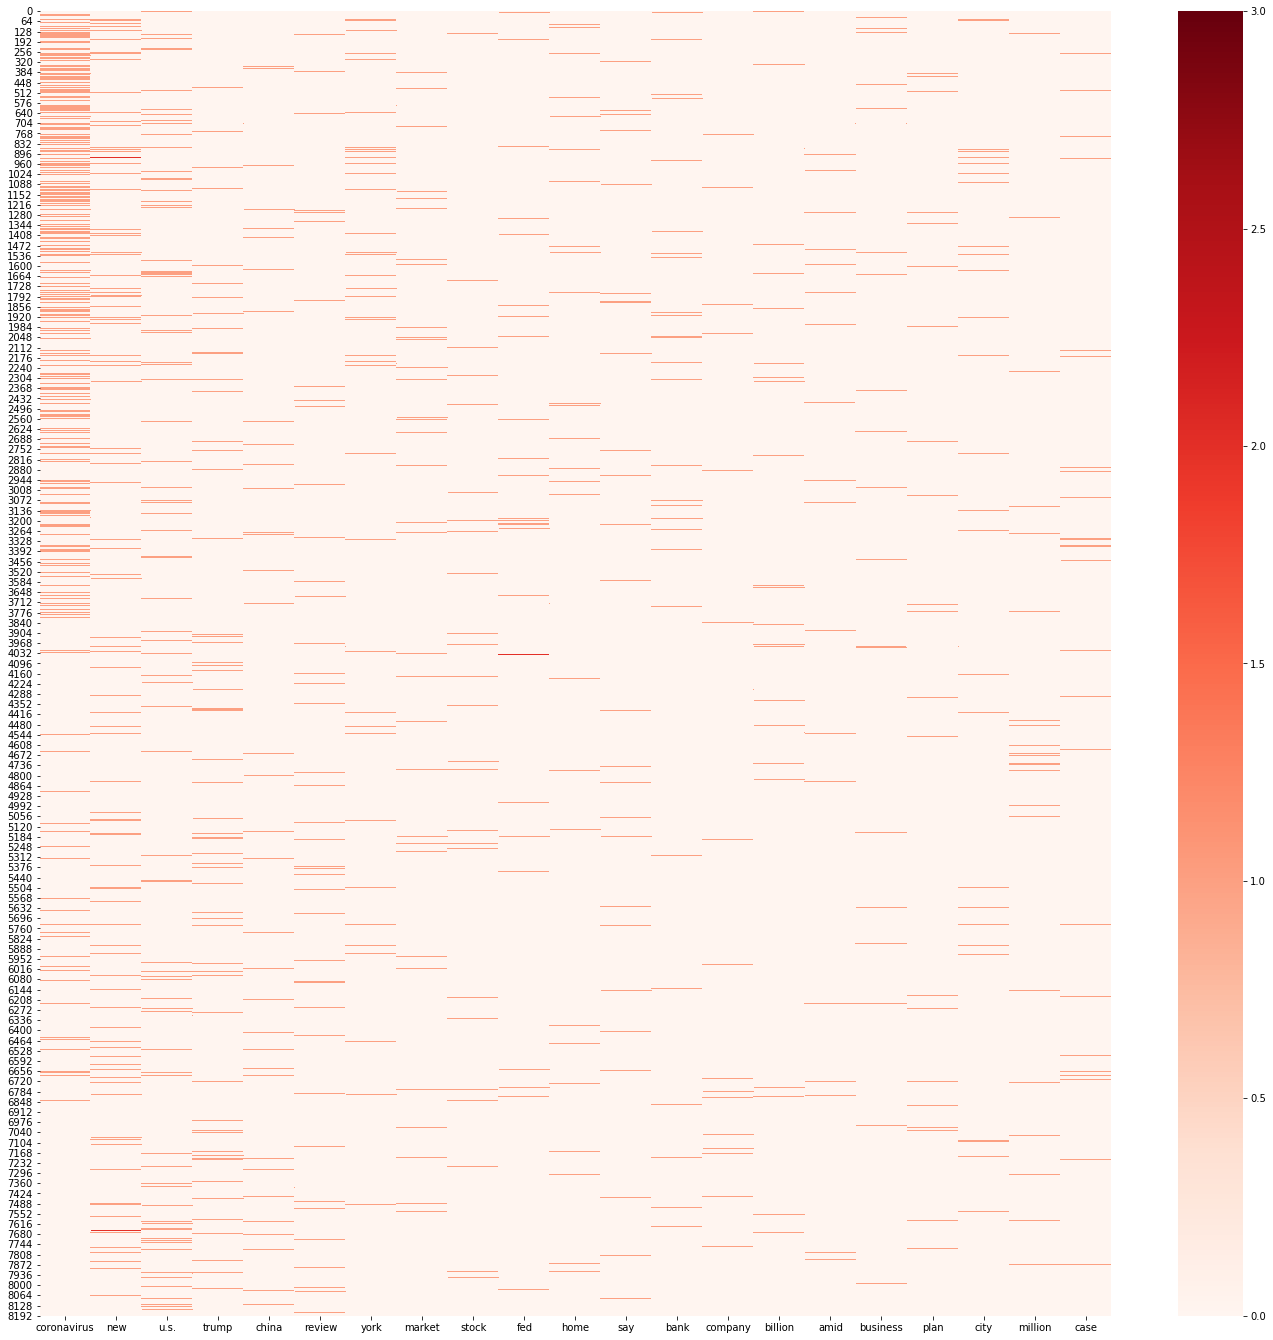

In [16]:
# 畫熱點圖驗證關鍵字的分佈情況
plt.figure(figsize=(24,24))
sn.heatmap(df_cooc_matrix,vmin = 0,vmax = 3,cmap='Reds')
plt.show()

## 共現性矩陣

In [17]:
# 計算共現性矩陣（轉置矩陣，矩陣相乘）
df_co = df_cooc_matrix.transpose()
co_mtx = df_co.dot(df_cooc_matrix)
co_mtx.head()

,coronavirus,new,u.s.,trump,china,review,york,market,stock,fed,...,say,bank,company,billion,amid,business,plan,city,million,case
coronavirus,1412,118,129,40,111,2,66,30,25,19,...,31,17,40,11,77,39,25,32,9,56
new,118,606,21,14,15,5,237,10,5,14,...,13,8,7,16,7,18,8,88,15,20
u.s.,129,21,551,18,39,2,4,12,14,8,...,16,17,21,8,14,12,8,4,3,12
trump,40,14,18,343,7,0,5,4,2,4,...,17,1,1,3,4,3,21,4,1,12
china,111,15,39,7,271,1,1,11,7,0,...,4,5,8,2,7,9,2,4,2,9


## 資料正則化

In [19]:
co_mtx_probability = np.divide(co_mtx,df_label_keyword['count'])
co_mtx_probability

,coronavirus,new,u.s.,trump,china,review,york,market,stock,fed,...,say,bank,company,billion,amid,business,plan,city,million,case
coronavirus,1.000000,0.202749,0.235832,0.116618,0.409594,0.007463,0.288210,0.132743,0.115207,0.113095,...,0.198718,0.117241,0.283688,0.080292,0.574627,0.291045,0.190840,0.246154,0.070866,0.444444
new,0.083569,1.041237,0.038391,0.040816,0.055351,0.018657,1.034934,0.044248,0.023041,0.083333,...,0.083333,0.055172,0.049645,0.116788,0.052239,0.134328,0.061069,0.676923,0.118110,0.158730
u.s.,0.091360,0.036082,1.007313,0.052478,0.143911,0.007463,0.017467,0.053097,0.064516,0.047619,...,0.102564,0.117241,0.148936,0.058394,0.104478,0.089552,0.061069,0.030769,0.023622,0.095238
trump,0.028329,0.024055,0.032907,1.000000,0.025830,0.000000,0.021834,0.017699,0.009217,0.023810,...,0.108974,0.006897,0.007092,0.021898,0.029851,0.022388,0.160305,0.030769,0.007874,0.095238
china,0.078612,0.025773,0.071298,0.020408,1.000000,0.003731,0.004367,0.048673,0.032258,0.000000,...,0.025641,0.034483,0.056738,0.014599,0.052239,0.067164,0.015267,0.030769,0.015748,0.071429
review,0.001416,0.008591,0.003656,0.000000,0.003690,1.000000,0.000000,0.000000,0.000000,0.005952,...,0.006410,0.000000,0.007092,0.007299,0.029851,0.007463,0.015267,0.007692,0.000000,0.000000
york,0.046742,0.407216,0.007313,0.014577,0.003690,0.000000,1.000000,0.022124,0.009217,0.023810,...,0.057692,0.020690,0.000000,0.043796,0.022388,0.052239,0.015267,0.623077,0.070866,0.119048
market,0.021246,0.017182,0.021938,0.011662,0.040590,0.000000,0.021834,1.000000,0.115207,0.154762,...,0.025641,0.048276,0.042553,0.087591,0.029851,0.014925,0.007634,0.015385,0.015748,0.000000
stock,0.017705,0.008591,0.025594,0.005831,0.025830,0.000000,0.008734,0.110619,1.000000,0.029762,...,0.006410,0.041379,0.000000,0.014599,0.037313,0.007463,0.000000,0.000000,0.007874,0.015873
fed,0.013456,0.024055,0.014625,0.011662,0.000000,0.003731,0.017467,0.115044,0.023041,1.047619,...,0.089744,0.151724,0.000000,0.175182,0.007463,0.000000,0.000000,0.000000,0.000000,0.000000


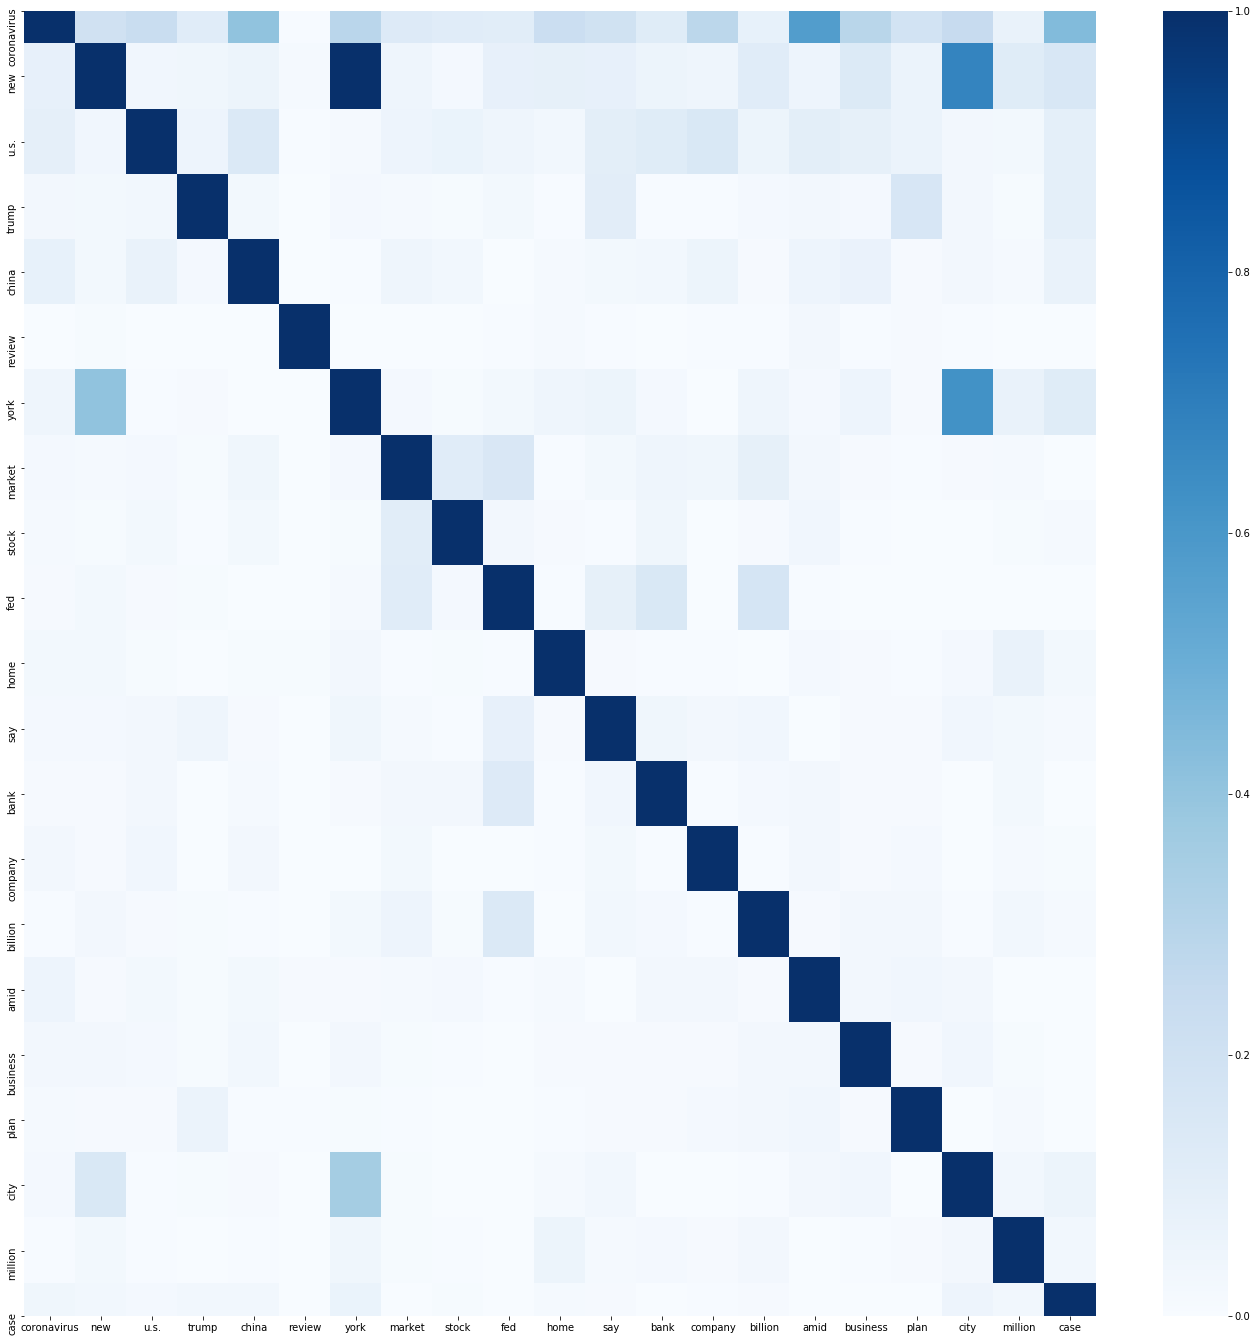

In [23]:
plt.figure(figsize=(24,24))
sn.heatmap(co_mtx_probability,vmin = 0,vmax = 1,cmap='Blues')
plt.show()

## 視覺化網絡圖

In [25]:
# 將内容轉換成 Graph 接受的形式
high_cor_list = []
for col_index in co_mtx_probability.columns:
    for row_index in co_mtx_probability.columns:
        if co_mtx[col_index][row_index] > 0:
            high_cor_list.append((col_index,row_index,co_mtx.loc[col_index][row_index]))

In [26]:
# 初始化無向圖，並將關鍵字與權重新增到 Graph 中
G_title = nx.Graph()
G_title.add_weighted_edges_from(high_cor_list)

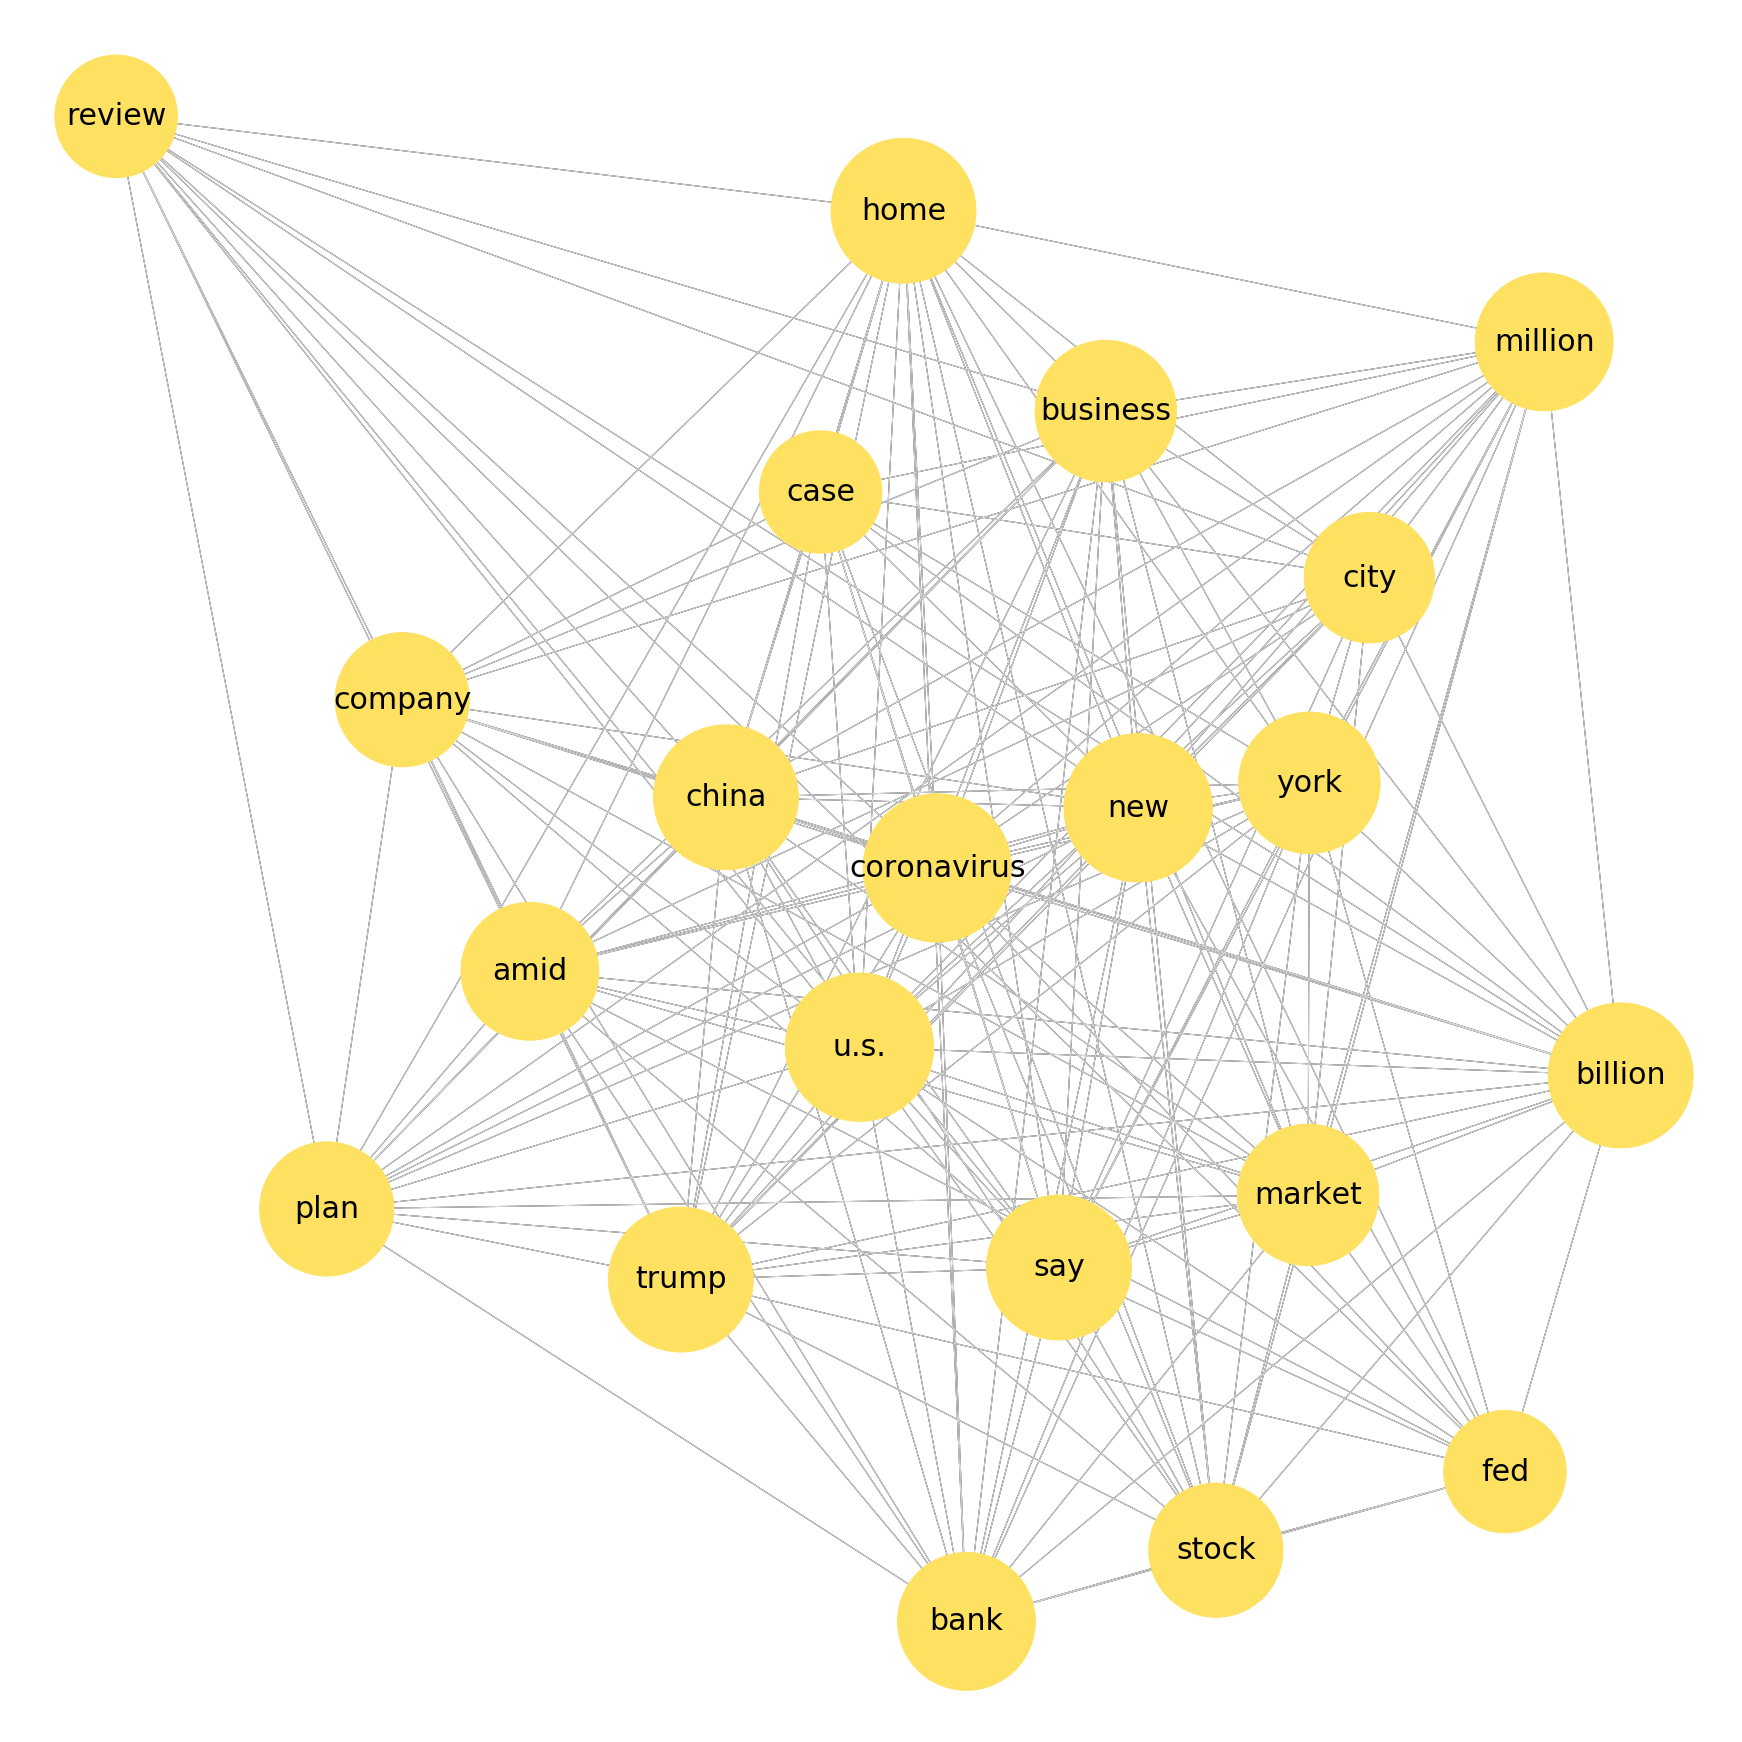

In [34]:
# 繪製關鍵字之網路圖
plt.figure(figsize=(24,24))
pos = nx.spring_layout(G_title)
nx.draw(G_title,pos,node_size = [val*1000 for (node, val) in G_title.degree()],node_color = '#FFE162')
nx.draw_networkx_labels(G_title, pos, font_size = 30,alpha = 1)
nx.draw_networkx_edges(G_title, pos, edge_color = '#DDDDDD', alpha = 1)
plt.show()

In [38]:
# 列出所有關鍵字的度
for keyword,val in G_title.degree():
    print(keyword + ' : ' + str(val) + ' Degree')

coronavirus : 22 Degree
new : 22 Degree
u.s. : 22 Degree
trump : 21 Degree
china : 21 Degree
review : 15 Degree
york : 20 Degree
market : 20 Degree
stock : 18 Degree
fed : 15 Degree
home : 21 Degree
say : 21 Degree
bank : 19 Degree
company : 18 Degree
billion : 21 Degree
amid : 19 Degree
business : 20 Degree
plan : 18 Degree
city : 17 Degree
million : 19 Degree
case : 15 Degree


## 關鍵字間的關係

#### 從這份簡易分析中可以瞭解到在近三個月中，因爲武漢肺炎的傳播，導致關鍵字（Coronavirus）成爲本次關鍵字中的中心節點，因此，在對應到野村專題中的債卷市場中，雖然沒有以時間序列的切入分析，但兩者之間存在高相關，因爲過程中一旦關鍵字（fed / trump / china）的出現，都會導致債卷市場出明顯波動效應。

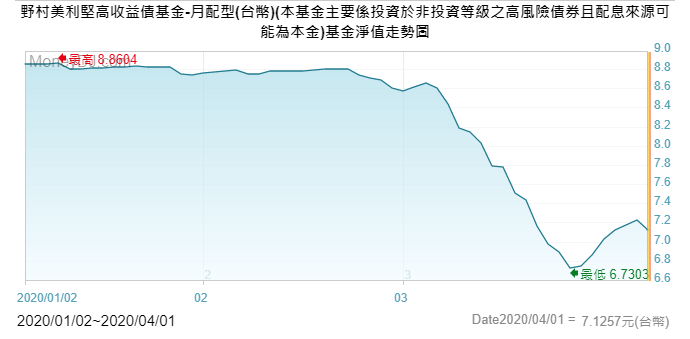



In [51]:
main_keyword = ['china','fed','trump']

def keyword_match(list_):
    for word in list_:
        if word in main_keyword:
            return 1
        else:
            return 0

df_ori['status'] = df_ori['title_edited'].apply(keyword_match)
list(df_ori[df_ori['status'] == 1]['date'].unique())

['1-4-2020',
 '31-3-2020',
 '29-3-2020',
 '28-3-2020',
 '27-3-2020',
 '26-3-2020',
 '25-3-2020',
 '24-3-2020',
 '23-3-2020',
 '22-3-2020',
 '21-3-2020',
 '20-3-2020',
 '19-3-2020',
 '18-3-2020',
 '17-3-2020',
 '16-3-2020',
 '15-3-2020',
 '14-3-2020',
 '13-3-2020',
 '12-3-2020',
 '11-3-2020',
 '10-3-2020',
 '9-3-2020',
 '8-3-2020',
 '7-3-2020',
 '6-3-2020',
 '5-3-2020',
 '4-3-2020',
 '3-3-2020',
 '2-3-2020',
 '1-3-2020',
 '29-2-2020',
 '28-2-2020',
 '27-2-2020',
 '26-2-2020',
 '25-2-2020',
 '24-2-2020',
 '22-2-2020',
 '21-2-2020',
 '20-2-2020',
 '19-2-2020',
 '18-2-2020',
 '16-2-2020',
 '15-2-2020',
 '14-2-2020',
 '13-2-2020',
 '12-2-2020',
 '11-2-2020',
 '11-2-2020\n',
 '10-2-2020',
 '9-2-2020',
 '8-2-2020',
 '7-2-2020',
 '6-2-2020',
 '5-2-2020',
 '4-2-2020',
 '3-2-2020',
 '2-2-2020',
 '1-2-2020',
 '31-1-2020',
 '30-1-2020',
 '29-1-2020',
 '28-1-2020',
 '27-1-2020',
 '26-1-2020',
 '25-1-2020',
 '24-1-2020',
 '23-1-2020',
 '22-1-2020',
 '21-1-2020',
 '20-1-2020',
 '19-1-2020',
 '19-1-20